In [24]:
# Load libraries
import sympy
import numpy as np
from collections import namedtuple
import pandas as pd
import cirq
import tensorflow as tf
import tensorflow_quantum as tfq
from tensorflow import keras
from sklearn.model_selection import train_test_split

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt

### Experimental setup

In [25]:
# Specify data path
path = "../data/gtzan_30s_stats.csv"
# Specify genres to build classification model from, options are:
# blues, classical, country, disco, hiphop, jazz, metal, pop, reggae, rock 
target_pair = ["rock", "reggae"]

In [26]:
# Read data
raw = pd.read_csv(path)
# Specify target column
target = "label"
# Specify columns to remove
columns_to_remove = ["filename", "length", target]
# Seperate X (features) and y (target) from dataset
y = raw.loc[:, target]
X = raw.drop(columns_to_remove, axis=1)
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
)
# Use a named typle to keep track of the changes to train and test samples
Samples = namedtuple("Samples", ["X_train", "y_train", "X_test", "y_test"])
# samples_raw is an instance of Samples, containing the raw samples
# access train features by samples_raw.X_train
samples_raw = Samples(X_train, y_train, X_test, y_test)

In [27]:
# Filter out unneccesary data, only store songs with labels specified in target_pair
train_filter = np.where(
    (samples_raw.y_train == target_pair[0]) | (samples_raw.y_train == target_pair[1])
)
test_filter = np.where(
    (samples_raw.y_test == target_pair[0]) | (samples_raw.y_test == target_pair[1])
)
X_train_filtered, X_test_filtered = (
    samples_raw.X_train.iloc[train_filter],
    samples_raw.X_test.iloc[test_filter],
)
y_train_filtered, y_test_filtered = (
    samples_raw.y_train.iloc[train_filter],
    samples_raw.y_test.iloc[test_filter],
)
# Convert target to binary int values, (genre_1, genre_2)->(0,1)
y_train_filtered = np.where(y_train_filtered == target_pair[1], 1, 0)
y_test_filtered = np.where(y_test_filtered == target_pair[1], 1, 0)
# samples_filtered now contains the latest X, y train and test data
samples_filtered = Samples(
    X_train_filtered, y_train_filtered, X_test_filtered, y_test_filtered
)

### Preprocessing

**Feature Selection**

In [28]:
# Manually specify features to build model on, this can be automated with feature selection strategies like tree based or PCA
features = ['mfcc2_var', 'mfcc3_var', 'mfcc4_var', 'mfcc5_var', 'mfcc7_var',
       'mfcc8_var', 'mfcc11_mean', 'mfcc13_mean']
X_train_selected = np.array(samples_filtered.X_train[features])
X_test_selected = np.array(samples_filtered.X_test[features])

samples_selected = Samples(
    X_train_selected, samples_filtered.y_train, X_test_selected, samples_filtered.y_test
)

**Feature Scaling**

In [29]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
# Create a pipeline_list which will contain preprocessing steps
pipeline_list = []
# For now we only scale the data, but more complicated pipelines can be constructed with this pattern, such as PCA, tree based feature selection
scaler = (
    "minmax",
    MinMaxScaler(feature_range=[0, np.pi / 2]),
)
pipeline_list.append(scaler)
# selector = ("pca", PCA(n_components=8))
# pipeline_list.append(selector)

pipeline = Pipeline(pipeline_list)
# Fit pipeline
pipeline.fit(samples_selected.X_train, samples_selected.y_train)
# Transform data
X_train_tfd = pipeline.transform(samples_selected.X_train)
X_test_tfd = pipeline.transform(samples_selected.X_test)
samples_tfd = Samples(
    X_train_tfd, samples_selected.y_train, X_test_tfd, samples_selected.y_test
)

### Encode data to a quantum state

In [30]:
def qubit_encoding(x, gate=cirq.rx):
    circuit = cirq.Circuit()
    for i, value in enumerate(x):
        qubit = cirq.LineQubit(i)
        circuit.append(gate(value).on(qubit))

    return circuit  

X_train_encoded = tfq.convert_to_tensor([qubit_encoding(x) for x in samples_tfd.X_train])
X_test_encoded = tfq.convert_to_tensor([qubit_encoding(x) for x in samples_tfd.X_test])

samples_encoded = Samples(
    X_train_encoded, samples_tfd.y_train, X_test_encoded, samples_tfd.y_test
)

### Build model

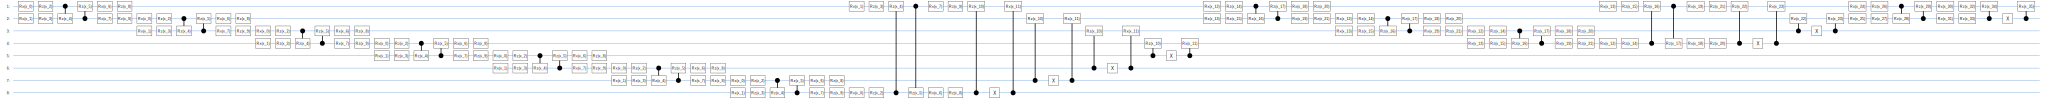

In [31]:
# import Qcnn which is a keras layer
from quantum_estimators import Qcnn_cirq as Qcnn
from cirq.contrib.svg import SVGCircuit
qcnn = Qcnn()
# display default circuit and configuration
SVGCircuit(qcnn.circuit)

In [32]:
def U(bits, symbols=None):
    circuit = cirq.Circuit()
    q0, q1 = cirq.LineQubit(bits[0]), cirq.LineQubit(bits[1])
    # circuit += cirq.H(q0)
    # circuit += cirq.H(q1)
    circuit += cirq.rz(symbols[0]).on(q1).controlled_by(q0)
    # circuit += cirq.rz(symbols[1]).on(q0).controlled_by(q1)
    return circuit


def V(bits, symbols=None):
    circuit = cirq.Circuit()
    q0, q1 = cirq.LineQubit(bits[0]), cirq.LineQubit(bits[1])
    circuit += cirq.CNOT(q0, q1)
    return circuit

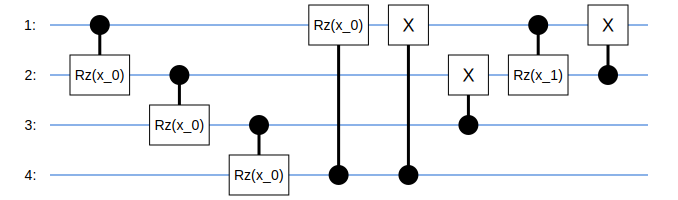

In [33]:
qcnn = Qcnn(n_q=4, s_c=1, s_p=0, pool_filter="right", convolution_mapping={1: (U, 1)}, pooling_mapping={1: (V, 0)})
SVGCircuit(qcnn.circuit)

Scale up model to 8 qubits, change convolution stride to $s_c=3$ 

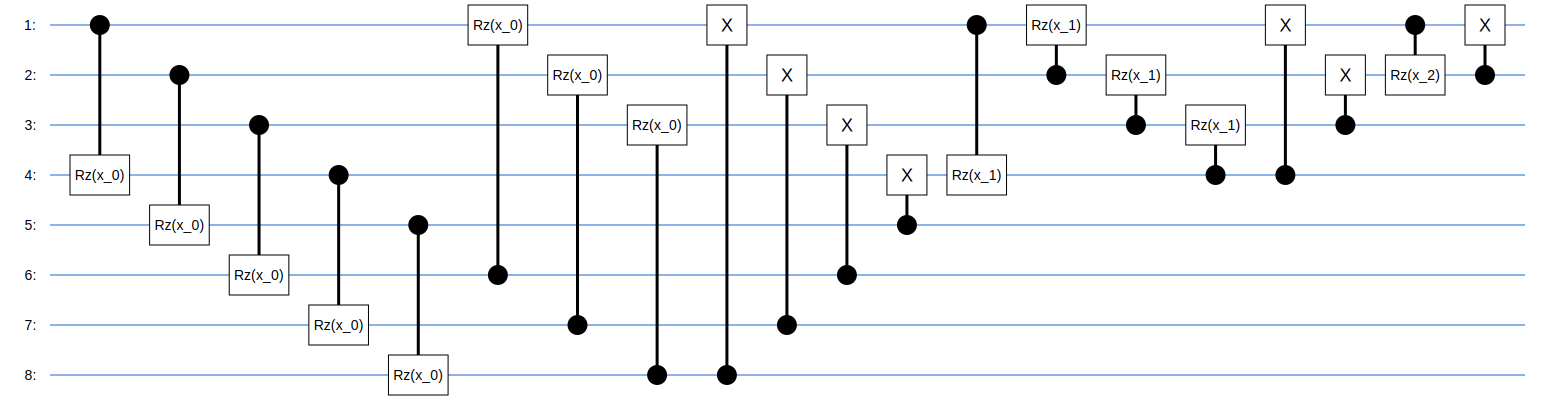

In [34]:
qcnn = Qcnn(n_q=8, s_c=3, s_p=0, pool_filter="right", convolution_mapping={1: (U, 1)}, pooling_mapping={1: (V, 0)})
SVGCircuit(qcnn.circuit)

In [35]:
print(f"Readout qubit: {qcnn.readout}")
print(f"Measure gate: {qcnn.ops_gate}")
print(f"Number of qubits: {qcnn.n_q}")
print(f"Convolution stride s_c: {qcnn.s_c}")
print(f"Pooling stride s_p: {qcnn.s_p}")

Readout qubit: 1
Measure gate: Z
Number of qubits: 8
Convolution stride s_c: 3
Pooling stride s_p: 0


In [36]:
import networkx as nx
def plot_qcnn_graphs(graphs, conv_color="#0096ff", pool_color="#ff7e79", **kwargs):
    # Get the first graph to derive some relevant information from the structure
    Qc_0 = list(graphs.values())[0][0][0]
    # The number of nodes of first graph
    n_qbits = len(Qc_0)
    # Change order around a circle, this way you start at x=0 then move left around
    theta_0 = 2 / n_qbits
    theta_step = 1 / n_qbits
    pos = {
        ind
        + 1: np.array(
            [
                np.cos(2 * np.pi * (theta_0 + ind * theta_step)),
                np.sin(2 * np.pi * (theta_0 + ind * theta_step)),
            ]
        )
        for ind in range(n_qbits)
    }
    figs = []
    for layer, ((Qc_l, Ec_l), (Qp_l, Ep_l)) in graphs.items():

        nx_c_graph = nx.DiGraph()
        nx_p_graph = nx.DiGraph()

        nx_c_graph.add_nodes_from(Qc_0)
        nx_c_graph.add_edges_from(Ec_l)
        node_c_sizes = [1000 if (q in Qc_l) else 200 for q in Qc_0]

        nx_p_graph.add_nodes_from(Qc_0)
        nx_p_graph.add_edges_from(Ep_l)
        node_p_sizes = [1000 if (q in [j for (i, j) in Ep_l]) else 200 for q in Qc_0]

        fig, ax = plt.subplots(figsize=(7, 7))
        nx.draw(
            nx_c_graph,
            pos,
            with_labels=True,
            node_size=node_c_sizes,
            edge_color="#000000",
            edgecolors="#000000",
            node_color=conv_color,
            width=1.5,
            **kwargs,
        )
        figs = figs + [fig]
        fig, ax = plt.subplots(figsize=(7, 7))
        nx.draw(
            nx_p_graph,
            pos,
            with_labels=True,
            node_size=node_p_sizes,
            edge_color="#000000",
            edgecolors="#000000",
            node_color=pool_color,
            width=1.5,
            **kwargs,
        )
        figs = figs + [fig]
    return figs

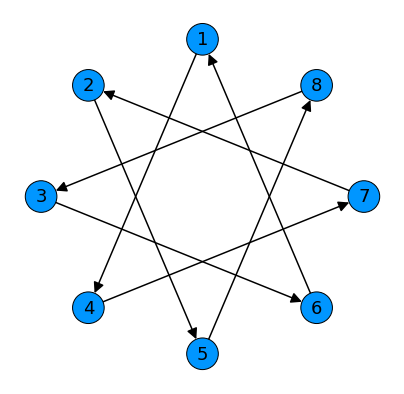

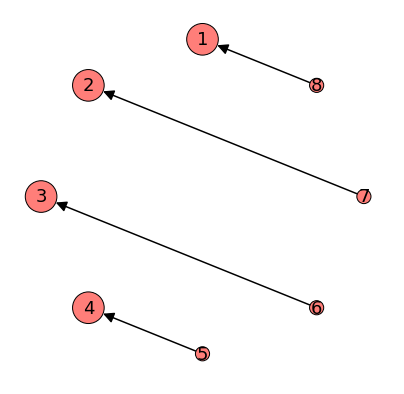

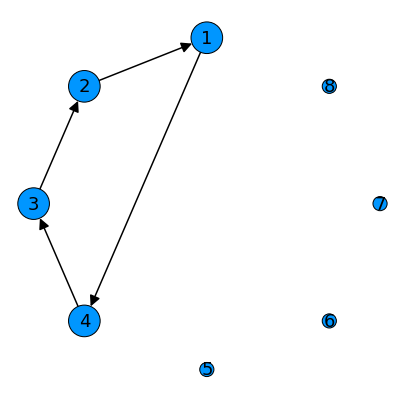

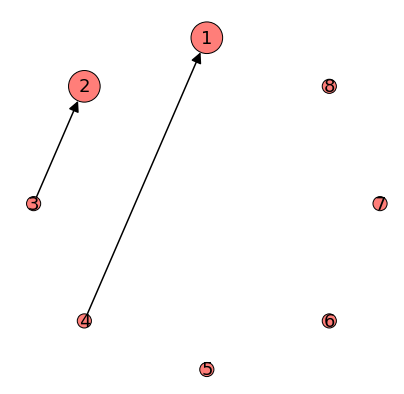

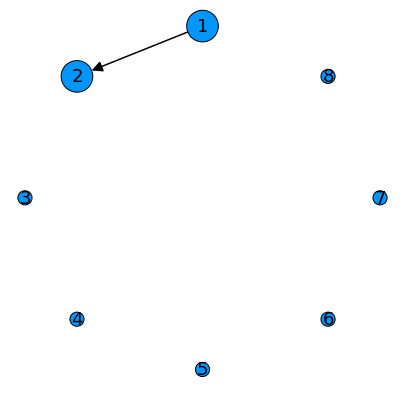

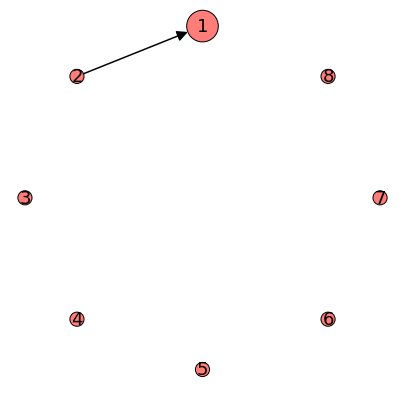

In [37]:
# TODO plot one at a time
figs = plot_qcnn_graphs(qcnn.graphs, arrowsize=22, font_size=18)

In [38]:
# === Specify hyperparamaters ===
# Number of qubits (since we're using qubit encoding ensure there is a one-one mapping between feature and qubit)
n_q = 8
# Convolution Stride
s_c = 5
# Pooling Stride
s_p = 0
# Pooling Filter, options: right, left, inside, outside, even, odd
pool_filter = "right"
model = tf.keras.Sequential(
        [
            # The Qcnn layer returns the expected value of the readout gate, range [-1,1]. By default readout is criq.Z and the model determines
            # which qubit to measure based on the one that's left over
            Qcnn(
                n_q=n_q,
                s_c=s_c,
                s_p=s_p,
                pool_filter=pool_filter,
            ),
            # Convert expectation values to lie between 0 and 1
            tf.keras.layers.Rescaling(1.0 / 2, offset=.5),
        ]
    )

In [39]:
model.compile(
    optimizer="Adam",
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5)],
)
# model.run_eagerly = True
model.fit(x=samples_encoded.X_train, y=samples_encoded.y_train, epochs=120)

Epoch 1/200
5/5 [==============================] - 2s 76ms/step - loss: 0.7111 - binary_accuracy: 0.1888
Epoch 2/200
5/5 [==============================] - 0s 76ms/step - loss: 0.7073 - binary_accuracy: 0.2448
Epoch 3/200
5/5 [==============================] - 0s 77ms/step - loss: 0.7036 - binary_accuracy: 0.2797
Epoch 4/200
5/5 [==============================] - 0s 76ms/step - loss: 0.7003 - binary_accuracy: 0.3497
Epoch 5/200
5/5 [==============================] - 0s 70ms/step - loss: 0.6967 - binary_accuracy: 0.4126
Epoch 6/200
5/5 [==============================] - 0s 80ms/step - loss: 0.6935 - binary_accuracy: 0.5175
Epoch 7/200
5/5 [==============================] - 0s 73ms/step - loss: 0.6900 - binary_accuracy: 0.6014
Epoch 8/200
5/5 [==============================] - 0s 74ms/step - loss: 0.6868 - binary_accuracy: 0.6853
Epoch 9/200
5/5 [==============================] - 0s 74ms/step - loss: 0.6835 - binary_accuracy: 0.7413
Epoch 10/200
5/5 [==============================] - 0s 

### Evaluate

In [41]:
model.summary()
print(model.trainable_variables)

qcnn_results = model.evaluate(samples_encoded.X_test, samples_encoded.y_test)
# results.append([f"{s_c}_{s_p}_{pool_filter}", qcnn_results])
print(qcnn_results)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 qcnn (Qcnn)                 (None, 1)                 36        
                                                                 
 rescaling (Rescaling)       (None, 1)                 0         
                                                                 
Total params: 36
Trainable params: 36
Non-trainable params: 0
_________________________________________________________________
[<tf.Variable 'Variable:0' shape=(1, 36) dtype=float32, numpy=
array([[0.72182715, 3.1647835 , 3.8177783 , 4.122626  , 5.4251814 ,
        1.0678426 , 1.1831585 , 5.466753  , 6.5700307 , 4.8250275 ,
        3.2115927 , 2.8749979 , 1.9697951 , 4.562392  , 5.6855173 ,
        5.4104114 , 3.7904587 , 3.7253213 , 5.9474936 , 1.6856445 ,
        4.3294396 , 6.3444986 , 5.413337  , 4.3913445 , 5.3178368 ,
        4.3165135 , 6.5200305 , 3.470139  , 2.9069455